# Analysing cavitation data

## Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from scipy import stats 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
import plotly
plotly.offline.init_notebook_mode()

In [3]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from rpy2.robjects.packages import importr
from rpy2.robjects import r, pandas2ri

base = importr('base') 
stats = importr('stats')
graphics = importr('graphics')
utils = importr('utils')
ade4 = importr('ade4')
nlme = importr('nlme')
lme4 = importr('lme4')
lmertest = importr('lmerTest')

from rpy2.robjects.conversion import localconverter

import rpy2.ipython.html
rpy2.ipython.html.init_printing()


## Useful functions & Class

In [4]:
def create_dict(keys, values):
    '''
    create dictionary from two lists
    '''
    dictionary = dict(zip(keys, values))
    return dictionary

In [5]:
def grouping_pop(df, level, start_rename):   
    '''
    creating summary tables with mean, std and n values per group defined by level
    '''
    df_mean = df.groupby(level).mean().reset_index().dropna(axis = 1)    
    temp_dict = [create_dict(df_mean.columns[start_rename::], df_mean.columns[start_rename::]+ i) for i in ['_mean', '_std']]
    df_mean = df_mean.rename(columns = temp_dict[0])    
    df_std = df.groupby(level).std().reset_index().dropna(axis = 1, thresh=5)    
    df_std= df_std.rename(columns = temp_dict[1])    
    df_n = df.groupby(level).size().reset_index(name='counts')    
    return df_mean, df_std, df_n

In [6]:
def plot_heatmap(cor, mode, ann=False):
    '''
    plot heatmap from a correlation matrix, 2 modes avalaible
    abs: compute the absolute values of the correlation matrix (values bounded between [0-1])
    cor: raw correlation values (values bounded between [-1-1])
    '''
    assert mode in ['cor','abs'], 'mode should be one of ["cor","abs"]'       
    if mode == 'cor':
        vm = -1
    else :
        vm = 0
        cor = np.abs(cor)        
    fig, ax = plt.subplots(figsize=(15, 15))# mask
    mask = np.triu(np.ones_like(cor, dtype=np.bool))# adjust mask and df
    mask = mask[1:, :-1]
    corr = cor.iloc[1:,:-1].copy()# plot heatmap    
    sns.heatmap(corr, mask=mask, annot=ann, fmt=".2f", cmap='Blues',
               vmin=vm, vmax=1, cbar_kws={"shrink": .8})# yticks
    plt.yticks(rotation=0)
    plt.show()

In [7]:
def mean_confidence_interval(sm, n, confidence=0.95, verbose = False): 
    '''
    compute the delta to mean value for computing confidence interval
    
    sm : standard deviation of the mean
    n : number of individuals
    
    return the delta to mean value for computing confidence interval (to be added to the mean value)
    '''
    from scipy import stats 

    def compute_t(confidence, ni):
        t=stats.t.ppf((1 + confidence) / 2., ni-1)
        return t    
    
    tval = [compute_t(confidence, ni) for ni in n]
    n = np.array(n)
    sm = np.array(sm)
    tval = np.array(tval)
    
    h = np.array(sm)/np.sqrt(n) * np.array(tval)
    if verbose:
        print('t values : {}'.format(np.around(tval, decimals=2)))
        print('\nse values : {}'.format(np.around(sm, decimals=2)))
        print('\nci values : {}'.format(np.around(h, decimals=2)))
    return h 


In [8]:
class MyPCA():
    '''
    file:///home/xavier/Downloads/fr_Tanagra_ACP_Python.pdf
    '''
    
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    import numpy as np
    import pandas as pd
    
    def __init__(self, df):
        self.df = df
        self.n = df.shape[0]
        self.p = df.shape[1]
        
    def standardize(self):
        sc = StandardScaler()
        self.Z = sc.fit_transform(self.df)
        
    def dopca(self):
        try:
            self.Z
        except:
            print("Z is not defined please standardize before")
            
        self.acp = PCA(svd_solver='full')
        self.coord = self.acp.fit_transform(self.Z)
        self.eigval = self.acp.explained_variance_
    
    def assess_pca(self):
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,6))
        ax1.bar(np.arange(1,self.p +1),self.acp.explained_variance_)
        ax1.set_title("Scree plot")
        ax1.set_ylabel("Eigen values")
        ax1.set_xlabel("Factor number")
       
        ax2.bar(np.arange(1,self.p+1),np.cumsum(self.acp.explained_variance_ratio_))
        ax2.set_title("Explained variance vs. # of factors")
        ax2.set_ylabel("Cumsum explained variance ratio")
        ax2.set_xlabel("Factor number")
        plt.show()
    
    def plot_indiv(self, label):
        fig, axes = plt.subplots(figsize=(12,12))
        axes.set_xlim(-6,6) #même limites en abscisse
        axes.set_ylim(-6,6) #et en ordonnée

        #placement des étiquettes des observations
        
        assert self.n == label.shape[0], 'rows number should have the same length than label'
        
        for i in range(self.n):
            plt.annotate(label[i],(self.coord[i,0],self.coord[i,1]))
        #ajouter les axes
        plt.plot([-6,6],[0,0],color='silver',linestyle='-',linewidth=1)
        plt.plot([0,0],[-6,6],color='silver',linestyle='-',linewidth=1)#affichage
        plt.show()        

    
    def _compute_corvar(self):
        print('computing factor variable correlation')
        sqrt_eigval = np.sqrt(self.eigval)
        #corrélation des variables avec les axes
        self.corvar = np.zeros((self.p,self.p))
        for k in range(self.p):
            self.corvar[:,k] = self.acp.components_[k,:] * sqrt_eigval[k]
            #afficher la matrice des corrélations variables x facteurs  
        
    def plot_features(self, label):
        self._compute_corvar()
        fig, axes = plt.subplots(figsize=(8,8))
        axes.set_xlim(-1,1)
        axes.set_ylim(-1,1)
        #affichage des étiquettes (noms des variables)
        
        assert self.p == label.shape[0], 'cols number should have the same length than label'
        
        for j in range(self.p):
            plt.annotate(label[j],(self.corvar[j,0],self.corvar[j,1]))

        #ajouter les axes
        plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
        plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

        #ajouter un cercle
        cercle = plt.Circle((0,0),1,color='blue',fill=False)
        axes.add_artist(cercle)

        #affichage
        plt.show()
        
        
    def compute_cos2(self):
        try:
            self.corvar
        except:
            print("corvar is not defined, use plot_features before")
            
        self.cos2var = self.corvar**2
        
        print('Axis 1\n---------------------------------------------\n')
        print(pd.DataFrame({'id':self.df.columns,'COS2_1':self.cos2var[:,0],'COS2_2':self.cos2var[:,1]}).sort_values('COS2_1', ascending = False))
        print('Axis 2\n---------------------------------------------\n')
        print(pd.DataFrame({'id':self.df.columns,'COS2_1':self.cos2var[:,0],'COS2_2':self.cos2var[:,1]}).sort_values('COS2_2', ascending = False))

        
        
        

## Plot of the pop

Temperature

![title](img/map1.png)

Aridity Index (lower = more arid)

![title](img/map4.png)

in black : *Pinus pinaster* populations

>Trabucco, A., and Zomer, R.J. 2018. Global Aridity Index and Potential
>Evapo-Transpiration (ET0) Climate Database v2. CGIAR Consortium for Spatial Information
>(CGIAR-CSI). Published online, available from the CGIAR-CSI GeoPortal at
>https://cgiarcsi.community

## Importing data

In [9]:
# import df
df = pd.read_table("/home/xavier/Documents/research/FORMANRISK/data/data_formanrisk/individual_join.csv", sep = ";")
# remove few columns
df = df.drop(columns = ["X","Y",'X_TYPE_', 'X_FREQ_', 'individual', 'branch_diam', 'branch_diamn','num', 
                        'P50n','P12n','P88n','slopen','Kmaxn'])
df = df.drop(columns=['email', 'info', 'x.1', 'y.1'])
print('dimensions of df are \nnrows : {0}\nncols : {1}'.format(df.shape[0], df.shape[1]))

dimensions of df are 
nrows : 440
ncols : 43


## Some data cleaning

### Renaming

In [10]:
# remove the _15 from bioclim var
df.columns = [re.sub("_15", "", c) for c in df.columns]
df = df.rename(columns={'AI':'bio20'})

In [11]:
# extracting index of bioclim var
bio_index  = [i for i, item in enumerate(df.columns) if re.search('bio\d{1,2}', item)]

In [12]:
# renaming bioclim var with meaningful names
keys = ["bio1" ,"bio2" ,"bio3" ,"bio4" ,"bio5" ,"bio6" ,"bio7" ,"bio8" ,"bio9" ,"bio10" ,"bio11" ,"bio12" ,"bio13" ,"bio14" ,"bio15" ,"bio16" ,"bio17" ,"bio18" ,"bio19", 'bio20']
values = ["Tmean_annual" ,"Mean_D_range" ,"Isothermality" ,"T_seasonality" ,"Tmax_warmerM" ,"Tmin_coldestM" ,"T_annual_range" ,"Tmean_wettestQ" ,"Tmean_driestQ" ,"Tmean_warmerQ" ,"Tmean_coldestQ" ,"P_annual" ,"P_wettestM" ,"P_driestM" ,"P_seasonality" ,"P_wettestQ" ,"P_driestQ" ,"P_warmestQ" ,"P_coldestQ", "Aridity_Index"]
dictionary = create_dict(keys,values)
df = df.rename(columns = dictionary)

In [13]:
df_oin = df[(df.site == 'oin_fr') | (df.site == 'oin_P')  | (df.site == 'oin_es')].reset_index()
df_oin = df_oin[['P50', 'site', 'Treatment']]

# keep only pop from oin_es
if False:
    df = df[(df.site != 'oin_fr') & (df.site != 'oin_P')].reset_index()
    print(df.site.unique())

# Convert all pop from oin to oin_es whatever the origin
if True:
    df.loc[(df.site == 'oin_fr') | (df.site == 'oin_P'),'site'] = 'oin_es'
    print(df.site.unique())
    
# remove all pop from oin
if False:
    df = df[(df.site != 'oin_fr') & (df.site != 'oin_P')  & (df.site != 'oin_es')].reset_index()
    print(df.site.unique())


['biscarrosse' 'cerbere' 'ceret' 'hourtin' 'la teste' 'leiria'
 'lit et mixe' 'mimizan' 'oin_es' 'perpignan' 'ribeira' 'san vicente'
 'spain dune' 'branas' 'orzaduero' 'llanos']


### summarizing df at pop level

In [14]:
# creating summary tables with mean, std and n values per group defined by level
df_pop_mean,df_pop_std,df_pop_n = grouping_pop(df=df, level=['Species','site'], start_rename=2)

In [15]:
# extracting labels of columns of interest
label_num = df_pop_mean.iloc[:,2::].columns

In [16]:
# concat mean, std and n summary tables
df_pop_mean = pd.concat([df_pop_mean,df_pop_std,df_pop_n], axis = 1)
# remove duplicated columns
df_pop_mean =df_pop_mean.loc[:,~df_pop_mean.columns.duplicated()]

### summarizing df at pop level with Treatment

In [17]:
# creating summary tables with mean, std and n values per group defined by level
df_pop_mean_T,df_pop_std_T ,df_pop_n_T  = grouping_pop(df=df, level=['Species','site','Treatment'], start_rename=3)

In [18]:
# concat mean, std and n summary tables
df_pop_mean_T = pd.concat([df_pop_mean_T ,df_pop_std_T ,df_pop_n_T ], axis = 1)
# remove duplicated columns
df_pop_mean_T =df_pop_mean_T.loc[:,~df_pop_mean_T.columns.duplicated()]

## Short Analysis of Oin Populations

In [19]:
fig = px.box(df_oin, x="site", y="P50", color = 'Treatment')
fig.show()

#### statistical tests: mixed model

In [20]:
# Import the linear regression model class
from pymer4.models import Lmer, Lm
# Initialize model using 2 predictors and sample data
model = Lm("P50 ~  Treatment ", data=df_oin)

# Fit it
print(model.fit())

Formula: P50~Treatment

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 54	 R^2: 0.004	 R^2_adj: -0.015

Log-likelihood: -14.994 	 AIC: 33.989	 BIC: 37.967

Fixed effects:

                    Estimate  2.5_ci  97.5_ci     SE  DF  T-stat  P-val  Sig
Intercept             -3.952  -4.069   -3.834  0.058  52 -67.592  0.000  ***
Treatment[T.young]     0.041  -0.139    0.221  0.090  52   0.455  0.651     


In [21]:
# Import the linear regression model class
from pymer4.models import Lmer

# Initialize model using 2 predictors and sample data
model = Lmer("P50 ~  Treatment + (1|site)", data=df_oin)

# Fit it
print(model.fit())

Formula: P50~Treatment+(1|site)

Family: gaussian	 Inference: parametric

Number of observations: 54	 Groups: {'site': 3.0}

Log-likelihood: -17.825 	 AIC: 35.650

Random effects:

                 Name    Var    Std
site      (Intercept)  0.012  0.109
Residual               0.098  0.313

No random effect correlations specified

Fixed effects:

                Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)       -3.940  -4.106   -3.774  0.085   2.942 -46.545  0.000  ***
Treatmentyoung     0.045  -0.124    0.215  0.087  50.384   0.523  0.603     


### **Conclusions : Best AIC without site as random effect, site is not improving model, can be removed**

#### statistical tests: linear model

In [22]:
import statsmodels.api as sm
from statsmodels.formula.api import ols


oin_lm = ols('P50 ~ C(Treatment, Sum)+C(site, Sum)',
                data=df_oin).fit()

table = sm.stats.anova_lm(oin_lm, typ=2) # Type 2 ANOVA DataFrame
print(table)

                     sum_sq    df         F    PR(>F)
C(Treatment, Sum)  0.030523   1.0  0.311447  0.579284
C(site, Sum)       0.609166   2.0  3.107851  0.053433
Residual           4.900223  50.0       NaN       NaN


In [23]:
# import python data frame to R global environment
with localconverter(ro.default_converter + pandas2ri.converter):
    df_oin_r = ro.conversion.py2rpy(df_oin[['P50','site', 'Treatment']])

base.dim(df_oin_r)


<rpy2.robjects.vectors.IntVector object at 0x7f63f4159980> [RTYPES.INTSXP]
R classes: ('integer',)
[54, 3]

In [24]:
%load_ext rpy2.ipython

In [25]:
%%R -i df_oin_r
require(basics)

In [26]:
%%R
lm1 = lm(P50 ~ site + Treatment, data = df_oin_r)
summary(lm1)


Call:
lm(formula = P50 ~ site + Treatment, data = df_oin_r)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.59902 -0.20547  0.06641  0.21402  0.82338 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -3.79636    0.08922 -42.552   <2e-16 ***
siteoin_fr     -0.26653    0.10712  -2.488   0.0162 *  
siteoin_P      -0.14940    0.11224  -1.331   0.1892    
Treatmentyoung  0.04840    0.08672   0.558   0.5793    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3131 on 50 degrees of freedom
Multiple R-squared:  0.1141,	Adjusted R-squared:  0.06095 
F-statistic: 2.147 on 3 and 50 DF,  p-value: 0.1061



In [27]:
%%R
anova(lm1)

  Df     Sum.Sq    Mean.Sq   F.value     Pr..F.
1  2 0.60060607 0.30030304 3.0641771 0.05555107
2  1 0.03052319 0.03052319 0.3114469 0.57928411
3 50 4.90022322 0.09800446        NA         NA


python & R statistical packages leads to the same F and p values.

### **Conclusion : No difference between site (F=3.06, p=0.055), pooling all provenances from Oin should be considered**

##  Filter Pinus pinaster populations

In [28]:
# keeping only p pinaster pop
df_pp = df[df.Species == "pinus pinaster"]
df_mean_pp = df_pop_mean[df_pop_mean.Species == "pinus pinaster"]
df_mean_pp_T = df_pop_mean_T[df_pop_mean_T.Species == "pinus pinaster"]

In [29]:
fig = px.bar(df_mean_pp_T, x='site', y='counts',
             hover_data=['Treatment','counts'], color='Treatment',
             labels={'counts':'Nb indivs per site per Treatment (P. pinaster)'}, 
             height=400, barmode='group')
fig.show()

___

Data are cleaned, let's see now for some data exploration

## P50 measurements

### Individual level

In [30]:
fig = px.histogram(df_pp,  x="P50", color = 'Treatment', marginal="rug",
                   hover_data=df_pp.columns)
fig.show()

In [31]:
print("Mean P50 value is {0:.3f} with sd {1:.3f}".format(df_pp.P50.mean(),df_pp.P50.std()))

Mean P50 value is -3.819 with sd 0.324


In [32]:
print('\n'.join('{}: {:.3f}'.format(['P50 adult', 'P50 young'][k],j) for k,j in enumerate(df_pp.groupby('Treatment').P50.mean().values)))

P50 adult: -3.843
P50 young: -3.794


In [33]:
fig = px.box(df_pp, x="site", y="P50", color = 'Treatment')
fig.show()

### Population level

In [34]:
mci = mean_confidence_interval(sm = df_mean_pp_T.loc[df_mean_pp_T['Treatment']=='adult', "P50_std"],
                                                  n = df_mean_pp_T.loc[df_mean_pp_T['Treatment']=='adult', "counts"],
                              verbose = False)

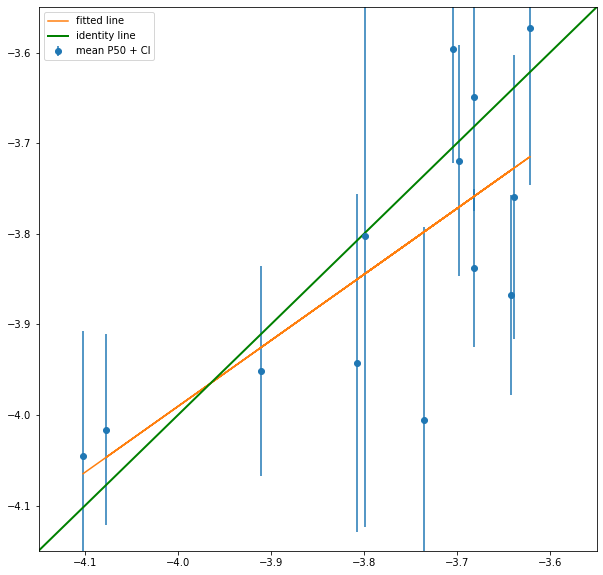

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))
X = df_mean_pp_T.loc[df_mean_pp_T['Treatment']=='young', "P50_mean"]
Y = df_mean_pp_T.loc[df_mean_pp_T['Treatment']=='adult', "P50_mean"]
plt.errorbar(X, Y, yerr=mci, fmt='o', label = 'mean P50 + CI')
plt.xlim([-4.15,-3.55])
plt.ylim([-4.15,-3.55])

m, b = np.polyfit(X, Y, 1)
plt.plot(X, m*X + b, label = 'fitted line')

plt.plot( [-5,1],[-5,1], c = 'green', lw=2, label = 'identity line')

plt.legend()

plt.show()

In [36]:
fig = px.scatter(x=df_mean_pp_T.loc[df_mean_pp_T['Treatment']=='young', "P50_mean"], 
                 y=df_mean_pp_T.loc[df_mean_pp_T['Treatment']=='adult', "P50_mean"], 
                 trendline="ols",
                 error_y=mci, 
                 error_y_minus=mci,
                 labels={
                     "x": "P50 mean young",
                     "y": "P50 Mean adult"                     
                 },
                title="P50 of adults vs P50 pof youngs per population with 95% confidence interval of the mean",
                range_x=[-4.15,-3.55],
                range_y=[-4.15,-3.55],
                width = 700,
                height = 700)
fig.show()

results = px.get_trendline_results(fig)

print('Statistics summary\n-------------------------\n')
results.px_fit_results.iloc[0].summary()

Statistics summary
-------------------------



/home/xavier/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=13



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     12.10
Date:                Mon, 08 Feb 2021   Prob (F-statistic):            0.00516
Time:                        17:15:09   Log-Likelihood:                 10.623
No. Observations:                  13   AIC:                            -17.25
Df Residuals:                      11   BIC:                            -16.12
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0785      0.791     -1.363      0.200      -2.820       0.663
x1             0.7280      0.209      3.478      0.005       0.267       1.189
==============================================================================
Omnibus:                        0.148   Durbin-Watson:                   2.275
Prob(Omnibus):                  0.929   Jarque-Bera (JB):                0.325
Skew:                          -0.179   Prob(JB):                        0.850
Kurtosis:                       2.314   Cond. No.                         99.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There is a significant correlation between young and adult P50 (R² = 0.54, F=15.24, p = 0.0018) The estimated value of the slope is 0.69 (t = 3.9, p = 0.002)

### Populations ratio between Treatment

In [37]:
ratio = df_mean_pp_T.loc[df_mean_pp_T['Treatment']=='young', "P50_mean"].values/df_mean_pp_T.loc[df_mean_pp_T['Treatment']=='adult', "P50_mean"].values

In [38]:
df_mean_pp_T['P50_ratio']=np.repeat(ratio,2)

<ipython-input-38-6cff8c2d3c7a>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



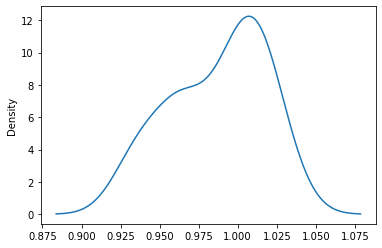

In [39]:
df_mean_pp_T['P50_ratio'].plot(kind='density')

(0.0, 1.0)

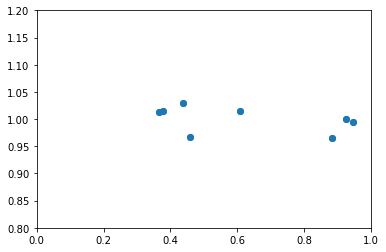

In [40]:
plt.scatter(df_mean_pp_T['Aridity_Index_mean'], df_mean_pp_T['P50_ratio'])
plt.ylim([0.8,1.2])
plt.xlim([0,1])

## Link between bioclim variables &  P50 

### Correlations between variables at the population level

<ipython-input-6-db19d28950b5>:14: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



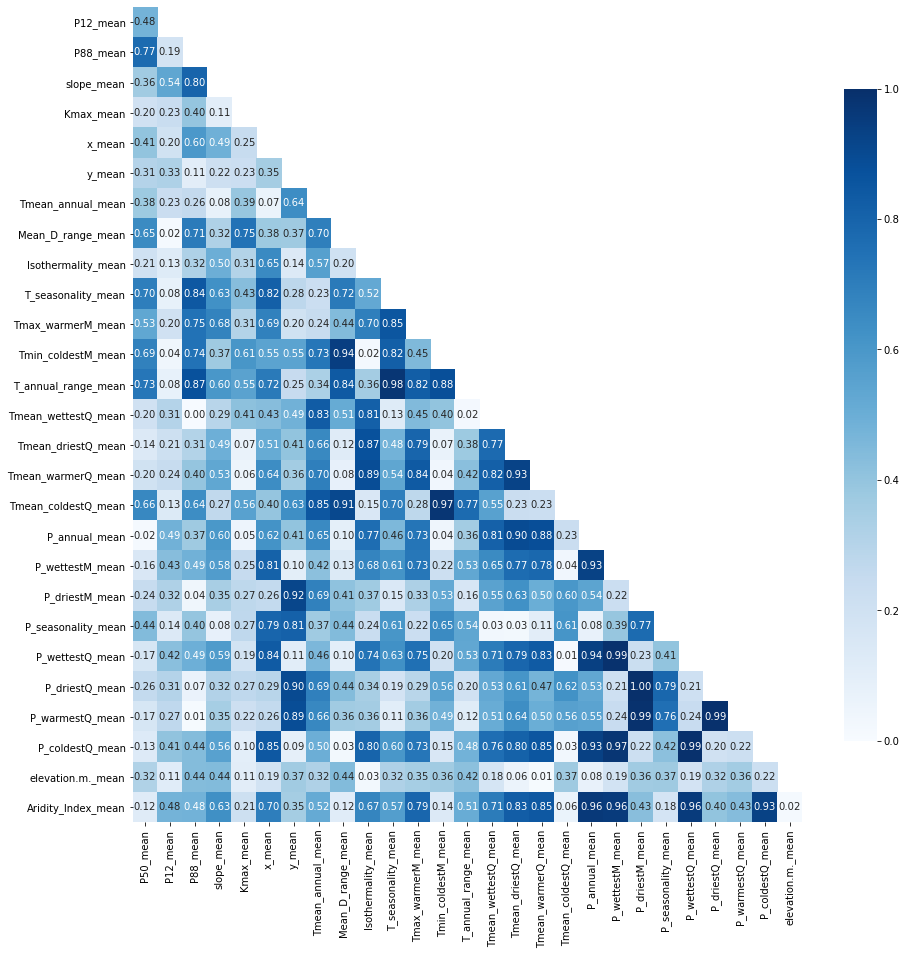

In [41]:
# mean values per population
df_corr= df_mean_pp[label_num].corr()
plot_heatmap(cor=df_corr, mode='abs', ann=True)

Strongest correlation between P50 and:
- Mean d range
- T season
- Tmin coldest
- T annual range
- T coldest Q


### Pairwise comparisons

#### Individual level

In [42]:
import plotly.express as px

fig = px.scatter(df_pp, x="Tmean_annual", y="P50", color="Treatment", trendline="ols", title = 'P50 vs Tmean')
fig.show()

results = px.get_trendline_results(fig)
print(results)

# results.query("Treatment == 'adult'").px_fit_results.iloc[0].summary()
# results.query("Treatment == 'young'").px_fit_results.iloc[0].summary()

  Treatment                                     px_fit_results
0     adult  <statsmodels.regression.linear_model.Regressio...
1     young  <statsmodels.regression.linear_model.Regressio...


In [43]:
import plotly.express as px

fig = px.scatter(df_pp, x="Aridity_Index", y="P50", color="Treatment", trendline="ols", title = 'P50 vs Aridity_index')
fig.show()

results = px.get_trendline_results(fig)
print(results)

  Treatment                                     px_fit_results
0     adult  <statsmodels.regression.linear_model.Regressio...
1     young  <statsmodels.regression.linear_model.Regressio...


Very weak R² between individuals measure of P50 and T mean annual of the pop (R² = 0.02 and 0.06)

#### Population level

*Without the Treatment effect*

In [44]:
df_mean_pp_wide = df_mean_pp[["Tmean_annual_mean",
                                  'Tmean_coldestQ_mean',
                                  'T_seasonality_mean',
                                  'T_annual_range_mean',
                                  'Tmin_coldestM_mean',
                                  "P50_mean",
                                  "Aridity_Index_mean",                                  
                                  'site']]


df_mean_pp_wide = pd.melt(df_mean_pp_wide, 
                            id_vars=[
                                     'site', 
                                     "P50_mean"], 
                            value_vars=["Tmean_annual_mean",
                                        'Tmean_coldestQ_mean',
                                        'T_seasonality_mean',
                                        'T_annual_range_mean',
                                        'Tmin_coldestM_mean',
                                        "Aridity_Index_mean"
                                        ])

df_mean_pp_wide.columns

Index(['site', 'P50_mean', 'variable', 'value'], dtype='object')

In [45]:
fig = px.scatter(df_mean_pp_wide, 
                 x="value", 
                 y="P50_mean", 
                
                 trendline="ols", 
                 text = "site",
                 facet_col="variable", 
                 facet_col_wrap=3,
                 facet_row_spacing=0.04, # default is 0.07 when facet_col_wrap is used
                 facet_col_spacing=0.04, # default is 0.03
                 height=800, width=1000)
fig.update_traces(textposition='top center')
fig.update_xaxes(matches=None)
fig.show()

**NB : Oin (es, fr & P) is a common garden located in corogna (spain) with 3 provenances (spanish, portugese (Leiria) and Frecnh)**

*With the Treament effect*

In [46]:
df_mean_pp_T_wide = df_mean_pp_T[["Tmean_annual_mean",
                                  'Tmean_coldestQ_mean',
                                  'T_seasonality_mean',
                                  'T_annual_range_mean',
                                  'Tmin_coldestM_mean',
                                  "P50_mean",
                                  "Treatment",
                                  "Aridity_Index_mean",
                                  'site']]


df_mean_pp_T_wide = pd.melt(df_mean_pp_T_wide, 
                            id_vars=["Treatment", 
                                     'site', 
                                     "P50_mean"], 
                            value_vars=["Tmean_annual_mean",
                                        'Tmean_coldestQ_mean',
                                        'T_seasonality_mean',
                                        'T_annual_range_mean',
                                        'Tmin_coldestM_mean',
                                        "Aridity_Index_mean"
                                        ])

df_mean_pp_T_wide.columns

Index(['Treatment', 'site', 'P50_mean', 'variable', 'value'], dtype='object')

In [47]:
fig = px.scatter(df_mean_pp_T_wide, 
                 x="value", 
                 y="P50_mean", 
                 color="Treatment", 
                 trendline="ols", 
                 text = "site",
                 facet_col="variable", 
                 facet_col_wrap=3,
                 facet_row_spacing=0.04, # default is 0.07 when facet_col_wrap is used
                 facet_col_spacing=0.04, # default is 0.03
                 height=800, width=1000)
fig.update_traces(textposition='top center')
fig.update_xaxes(matches=None)
fig.show()

# ARIDITY INDEX

In [48]:
import plotly.express as px

fig = px.scatter(df_mean_pp_T, x="Aridity_Index_mean", y="P50_mean", color="Treatment", trendline="ols",
                 text = "site", title = 'P50 vs Aridity_index')
fig.update_traces(textposition='top center')
fig.show()


Results:

Some traits some to be more correlated to p50 as seen on the heatmap, with maybe some slight differences between treatment

## PCA on bioclim var

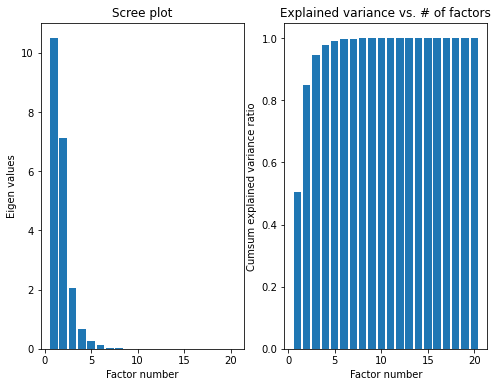

In [49]:
mypca = MyPCA(df_mean_pp_T[[v +'_mean' for v in values]] )
mypca.standardize()
mypca.dopca()
mypca.assess_pca()

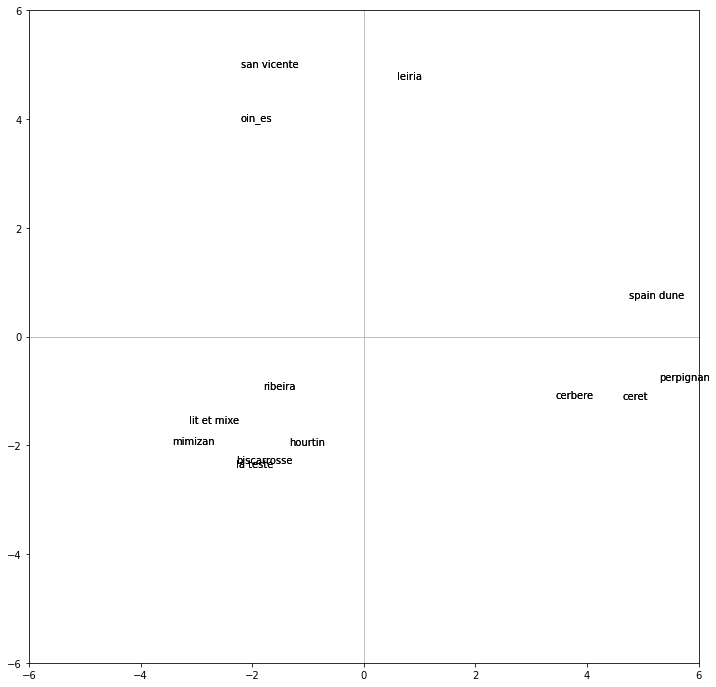

In [50]:
mypca.plot_indiv(label = df_mean_pp_T.site)

computing factor variable correlation


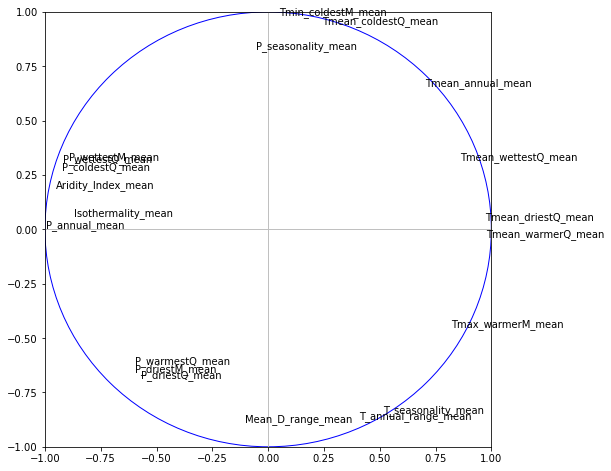

In [51]:
mypca.plot_features(label = df_mean_pp_T[[v +'_mean' for v in values]].columns)

In [52]:
mypca.compute_cos2()

Axis 1
---------------------------------------------

                     id    COS2_1    COS2_2
11        P_annual_mean  0.988560  0.000098
9    Tmean_warmerQ_mean  0.954697  0.001158
8    Tmean_driestQ_mean  0.947981  0.002187
19   Aridity_Index_mean  0.904223  0.035924
18      P_coldestQ_mean  0.856054  0.074427
15      P_wettestQ_mean  0.844006  0.095567
12      P_wettestM_mean  0.795931  0.102343
2    Isothermality_mean  0.760038  0.003926
7   Tmean_wettestQ_mean  0.739797  0.102577
4     Tmax_warmerM_mean  0.675203  0.201207
0     Tmean_annual_mean  0.491412  0.435909
17      P_warmestQ_mean  0.356465  0.378610
13       P_driestM_mean  0.353853  0.427526
16       P_driestQ_mean  0.326673  0.463796
3    T_seasonality_mean  0.263646  0.708870
6   T_annual_range_mean  0.164619  0.758039
10  Tmean_coldestQ_mean  0.058240  0.895339
1     Mean_D_range_mean  0.010754  0.786059
14   P_seasonality_mean  0.002764  0.690470
5    Tmin_coldestM_mean  0.002356  0.974097
Axis 2
---------------

### Plot P50 again PCA axis

In [53]:
acp_coord = pd.DataFrame(mypca.coord, columns = ['acp_'+str(i) for i in np.arange(0,mypca.coord.shape[1])])
df_mean_pp_T_acp = pd.concat([df_mean_pp_T, acp_coord], axis = 1)

In [54]:
fig = px.scatter(df_mean_pp_T_acp, x="acp_0", y="P50_mean", color="Treatment", trendline="ols",
                 text = "site")
fig.update_traces(textposition='top center')
fig.show()


In [55]:
fig = px.scatter(df_mean_pp_T_acp, x="acp_1", y="P50_mean", color="Treatment", trendline="ols",
                 text = "site")
fig.update_traces(textposition='top center')
fig.show()

It seems that the correlation is better between p50 and the second axis of the PCA (R² = 0.23, 0.26) but it is not super wonderful, maybe fit a non linear model

first axis is associated with :
- (+) Tmean warmer Quarter
- (+) Tmean driest Quarter
- (-) P coldest Quarter
- (-) Aridity_Index_mean

second axis is associated with :
- (+) Tmin coldest Month
- (+) Tmean coldest Quarter

## ACP on complete data set

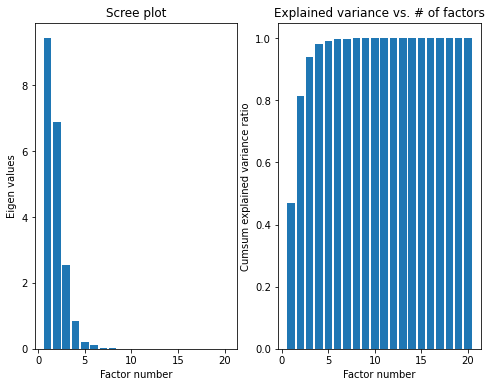

In [56]:
mypca = MyPCA(df_pp.iloc[:,bio_index])
mypca.standardize()
mypca.dopca()
mypca.assess_pca()

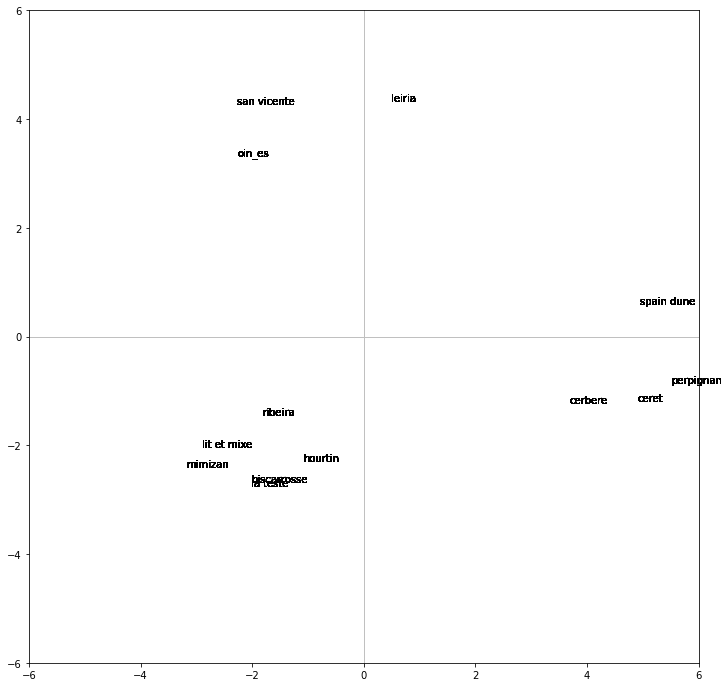

In [57]:
mypca.plot_indiv(label = df_pp.site)

In [58]:
acp_coord = pd.DataFrame(mypca.coord, columns = ['acp_'+str(i) for i in np.arange(0,mypca.coord.shape[1])])
df_pp_acp = pd.concat([df_pp, acp_coord], axis = 1)

### Saving data frame

In [59]:
def create_group(df, group, col = 'site', Name = 'Groupclim'): 
    
    gr = 1
    for g in group:
        for i in g:
            df.loc[df[col]==i,Name] = 'group_'+str(gr)
        gr+=1
    
    return df
    

In [60]:
ll=['leiria', 'oin_es', 'san vicente']+['cerbere','ceret', 'perpignan', 'spain dune']

In [61]:
pp= ['biscarrosse', 'cerbere', 'ceret', 'hourtin', 'la teste', 'leiria',
 'lit et mixe', 'mimizan', 'oin_es' ,'perpignan', 'ribeira' ,'san vicente','spain dune' ,'branas' ,'orzaduero', 'llanos']

In [62]:
# Group based on ACP clusters

group = [['leiria', 'oin_es', 'san vicente'],
        ['cerbere','ceret', 'perpignan', 'spain dune'],
        ['biscarrosse', 'branas', 'hourtin', 'la teste', 'lit et mixe',
         'llanos', 'mimizan', 'orzaduero', 'ribeira']]

group = [['leiria', 'oin_es', 'san vicente'],
        ['cerbere','ceret', 'perpignan', 'spain dune'],
        ['biscarrosse', 'branas', 'hourtin', 'la teste', 'lit et mixe',
         'llanos', 'mimizan', 'orzaduero', 'ribeira']]

In [63]:
df_mean_pp_T_acp= create_group(df= df_mean_pp_T_acp,
                               group = group,
                               col = 'site')

In [64]:
df_pp_acp = create_group(df= df_pp_acp,
                             group = group,
                             col = 'site')

In [65]:
if True:
    df_mean_pp_T_acp.to_csv("/home/xavier/Documents/research/FORMANRISK/analyse/forman_cavit/output/table/df_mean_PP.csv")
    df_pp_acp.to_csv("/home/xavier/Documents/research/FORMANRISK/analyse/forman_cavit/output/table/df_PP.csv")

In [66]:
df_pp_acp.columns

Index(['Species', 'site', 'Treatment', 'P50', 'P12', 'P88', 'slope', 'Kmax',
       'P50e', 'P12e', 'P88e', 'slopee', 'Kmaxe', 'branch_diame', 'x', 'y',
       'Tmean_annual', 'Mean_D_range', 'Isothermality', 'T_seasonality',
       'Tmax_warmerM', 'Tmin_coldestM', 'T_annual_range', 'Tmean_wettestQ',
       'Tmean_driestQ', 'Tmean_warmerQ', 'Tmean_coldestQ', 'P_annual',
       'P_wettestM', 'P_driestM', 'P_seasonality', 'P_wettestQ', 'P_driestQ',
       'P_warmestQ', 'P_coldestQ', 'Country', 'elevation.m.', 'species_2',
       'sapling.age.yr..height.m.', 'adult.age.yr..height.m.',
       'sampling.dates', 'person.in.charge', 'Aridity_Index', 'acp_0', 'acp_1',
       'acp_2', 'acp_3', 'acp_4', 'acp_5', 'acp_6', 'acp_7', 'acp_8', 'acp_9',
       'acp_10', 'acp_11', 'acp_12', 'acp_13', 'acp_14', 'acp_15', 'acp_16',
       'acp_17', 'acp_18', 'acp_19', 'Groupclim'],
      dtype='object')

## Stats models

In [67]:
# Import the linear regression model class
from pymer4.models import Lm

# Initialize model using 2 predictors and sample data
model = Lm("P50 ~ Treatment + Aridity_Index + site", data=df_pp_acp)

# Fit it
print(model.fit())

Formula: P50~Treatment+Aridity_Index+site

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 406	 R^2: 0.220	 R^2_adj: 0.192

Log-likelihood: -67.374 	 AIC: 164.748	 BIC: 224.843

Fixed effects:

                     Estimate  2.5_ci  97.5_ci     SE   DF  T-stat  P-val  Sig
Intercept              -2.804  -2.862   -2.746  0.030  391 -94.372  0.000  ***
Treatment[T.young]      0.035  -0.022    0.092  0.029  391   1.206  0.228     
site[T.cerbere]        -0.409  -0.541   -0.276  0.067  391  -6.064  0.000  ***
site[T.ceret]          -0.381  -0.510   -0.251  0.066  391  -5.785  0.000  ***
site[T.hourtin]        -0.115  -0.268    0.038  0.078  391  -1.481  0.139     
site[T.la teste]        0.118  -0.043    0.280  0.082  391   1.437  0.152     
site[T.leiria]         -0.585  -0.708   -0.463  0.062  391  -9.383  0.000  ***
site[T.lit et mixe]     0.195   0.030    0.359  0.084  391   2.324  0.021    *
site[T.mimizan]     

In [68]:
import statsmodels.api as sm
from statsmodels.formula.api import ols


oin_lm = ols('P50 ~ C(Treatment)+Aridity_Index',
                data=df_pp_acp).fit()

# print(oin_lm.summary())
table = sm.stats.anova_lm(oin_lm, typ=2) # Type 2 ANOVA DataFrame
print(table)

                  sum_sq     df         F    PR(>F)
C(Treatment)    0.231398    1.0  2.210291  0.137875
Aridity_Index   0.052140    1.0  0.498031  0.480774
Residual       42.190633  403.0       NaN       NaN


In [69]:
df_restricted = df_pp_acp[['P50','site', 'Treatment', 'acp_0', 'acp_1', 'Groupclim', 'Aridity_Index']]

# Random intercept model

In [70]:
from pymer4.models import Lmer

# Initialize model instance using 1 predictor with random intercepts 
# this is the full model
model = Lmer("P50 ~ (1|site)", data=df_restricted)

# Fit it
print(model.fit())

Formula: P50~(1|site)

Family: gaussian	 Inference: parametric

Number of observations: 406	 Groups: {'site': 13.0}

Log-likelihood: -90.164 	 AIC: 180.327

Random effects:

                 Name    Var    Std
site      (Intercept)  0.021  0.143
Residual               0.085  0.291

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)    -3.808  -3.892   -3.725  0.042  12.246 -89.689    0.0  ***


### Full model

In [71]:
from pymer4.models import Lmer

# Initialize model instance using 1 predictor with random intercepts 
# this is the full model
model = Lmer("P50 ~ Treatment + acp_0 + acp_1 + (1|site)", data=df_restricted)

# Fit it
print(model.fit())

Formula: P50~Treatment+acp_0+acp_1+(1|site)

Family: gaussian	 Inference: parametric

Number of observations: 406	 Groups: {'site': 13.0}

Log-likelihood: -95.508 	 AIC: 191.015

Random effects:

                 Name    Var    Std
site      (Intercept)  0.012  0.111
Residual               0.085  0.291

No random effect correlations specified

Fixed effects:

                Estimate  2.5_ci  97.5_ci     SE       DF   T-stat  P-val  Sig
(Intercept)       -3.837  -3.910   -3.765  0.037   13.377 -103.375  0.000  ***
Treatmentyoung     0.034  -0.023    0.091  0.029  393.232    1.166  0.244     
acp_0              0.006  -0.015    0.027  0.011   10.237    0.590  0.568     
acp_1             -0.038  -0.065   -0.012  0.014    9.853   -2.825  0.018    *


In [72]:
print(model.anova())

SS Type III Analysis of Variance Table with Satterthwaite approximated degrees of freedom:
(NOTE: Using original model contrasts, orthogonality not guaranteed)
         SS        MS  NumDF     DenomDF    F-stat     P-val Sig
0  0.114802  0.114802      1  393.231569  1.358551  0.244495    
1  0.029411  0.029411      1   10.236902  0.348041  0.568017    
2  0.674410  0.674410      1    9.852811  7.980884  0.018253   *


### Full model with Aridity Index but no ACP axis

In [73]:
from pymer4.models import Lmer

# Initialize model instance using 1 predictor with random intercepts 
# this is the full model
model = Lmer("P50 ~ Treatment * Aridity_Index + (1|site)", data=df_restricted)

# Fit it
print(model.fit())

Formula: P50~Treatment*Aridity_Index+(1|site)

Family: gaussian	 Inference: parametric

Number of observations: 406	 Groups: {'site': 13.0}

Log-likelihood: -92.702 	 AIC: 185.403

Random effects:

                 Name    Var    Std
site      (Intercept)  0.022  0.148
Residual               0.084  0.290

No random effect correlations specified

Fixed effects:

                              Estimate  2.5_ci  97.5_ci     SE       DF  \
(Intercept)                     -3.717  -3.969   -3.465  0.129   13.609   
Treatmentyoung                  -0.107  -0.268    0.054  0.082  391.666   
Aridity_Index                   -0.130  -0.417    0.157  0.146   13.317   
Treatmentyoung:Aridity_Index     0.172  -0.009    0.353  0.092  392.316   

                              T-stat  P-val  Sig  
(Intercept)                  -28.923  0.000  ***  
Treatmentyoung                -1.302  0.194       
Aridity_Index                 -0.891  0.389       
Treatmentyoung:Aridity_Index   1.867  0.063    .  


In [74]:
print(model.anova())

SS Type III Analysis of Variance Table with Satterthwaite approximated degrees of freedom:
(NOTE: Using original model contrasts, orthogonality not guaranteed)
         SS        MS  NumDF     DenomDF    F-stat     P-val Sig
0  0.142363  0.142363      1  391.665740  1.695438  0.193651    
1  0.008409  0.008409      1   11.236571  0.100140  0.757463    
2  0.292564  0.292564      1  392.316011  3.484226  0.062702   .


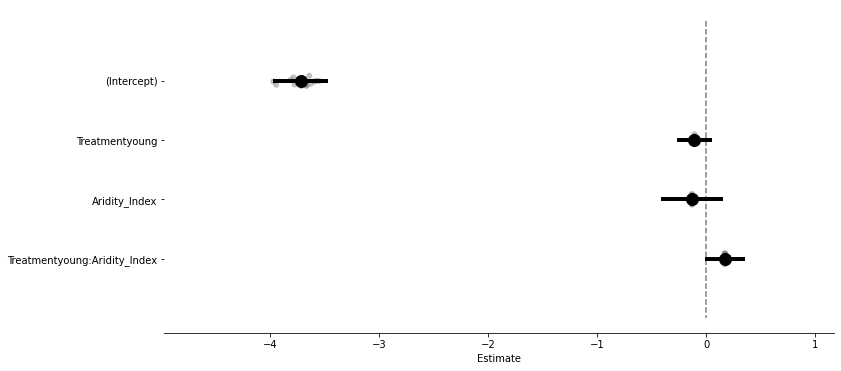

In [75]:
# Visualize coefficients with group/cluster fits overlaid ("forest plot")
model.plot_summary()

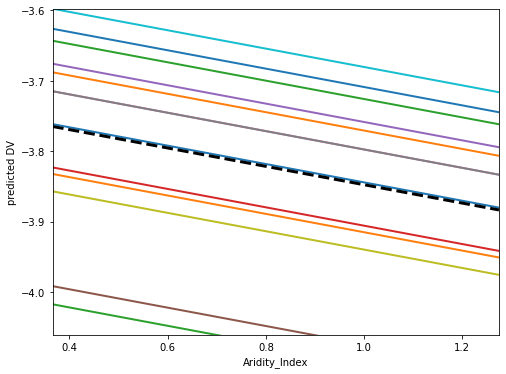

In [76]:
model.plot("Aridity_Index", plot_ci=False, ylabel="predicted DV")

### Simplest model with only Treatment & site as random

In [77]:
# Initialize model instance using 1 predictor with random intercepts 
# no climatic variables
model = Lmer("P50 ~ Treatment + (1|site)", data=df_restricted)

# Fit it
print(model.fit())

Formula: P50~Treatment+(1|site)

Family: gaussian	 Inference: parametric

Number of observations: 406	 Groups: {'site': 13.0}

Log-likelihood: -91.986 	 AIC: 183.971

Random effects:

                 Name    Var    Std
site      (Intercept)  0.020  0.142
Residual               0.084  0.291

No random effect correlations specified

Fixed effects:

                Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)       -3.826  -3.913   -3.739  0.044   15.08 -85.992  0.000  ***
Treatmentyoung     0.037  -0.020    0.094  0.029  393.95   1.263  0.207     


### Selected model (with & without interaction)

In [78]:
# Initialize model instance using 1 predictor with random intercepts 
model = Lmer("P50 ~ Treatment + acp_1 + (Treatment|site)", data=df_restricted)

# Fit it
print(model.fit())

boundary (singular) fit: see ?isSingular 

Formula: P50~Treatment+acp_1+(Treatment|site)

Family: gaussian	 Inference: parametric

Number of observations: 406	 Groups: {'site': 13.0}

Log-likelihood: -91.970 	 AIC: 183.940

Random effects:

                    Name    Var    Std
site         (Intercept)  0.013  0.113
site      Treatmentyoung  0.000  0.014
Residual                  0.084  0.291

              IV1             IV2  Corr
site  (Intercept)  Treatmentyoung  -1.0

Fixed effects:

                Estimate  2.5_ci  97.5_ci     SE       DF   T-stat  P-val  Sig
(Intercept)       -3.837  -3.911   -3.763  0.038   10.959 -101.691  0.000  ***
Treatmentyoung     0.034  -0.024    0.091  0.029  154.341    1.151  0.251     
acp_1             -0.039  -0.064   -0.013  0.013   10.831   -2.994  0.012    *


In [79]:
# Initialize model instance using 1 predictor with random intercepts and slopes
model = Lmer("P50 ~  Treatment + acp_1 + (1|site)", data=df_restricted)

# Fit it
print(model.fit())

Formula: P50~Treatment+acp_1+(1|site)

Family: gaussian	 Inference: parametric

Number of observations: 406	 Groups: {'site': 13.0}

Log-likelihood: -92.054 	 AIC: 184.107

Random effects:

                 Name    Var    Std
site      (Intercept)  0.011  0.107
Residual               0.085  0.291

No random effect correlations specified

Fixed effects:

                Estimate  2.5_ci  97.5_ci     SE       DF   T-stat  P-val  Sig
(Intercept)       -3.836  -3.907   -3.766  0.036   14.898 -106.291  0.000  ***
Treatmentyoung     0.034  -0.023    0.091  0.029  393.279    1.165  0.245     
acp_1             -0.038  -0.064   -0.012  0.013   10.749   -2.903  0.015    *


This is the best model based on AIC value (both models random intercep & random intercept + slope perform very similarly)

No effect of treatment
effect on acp_1 which is the second axis of the pca correlated with :

- (+) Tmin coldest Quarter
- (+) Tmin coldest Month

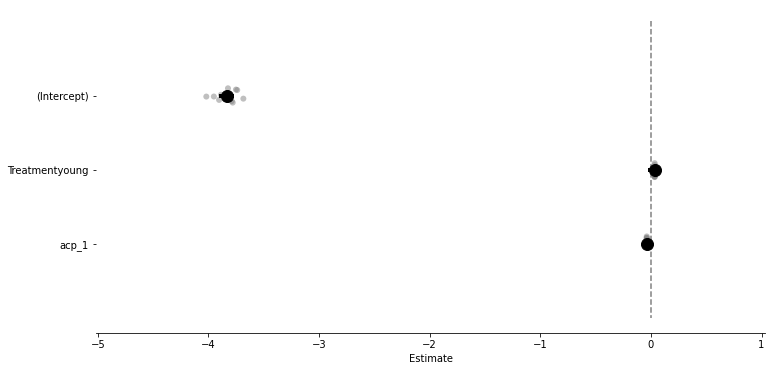

In [80]:
# Visualize coefficients with group/cluster fits overlaid ("forest plot")
model.plot_summary()

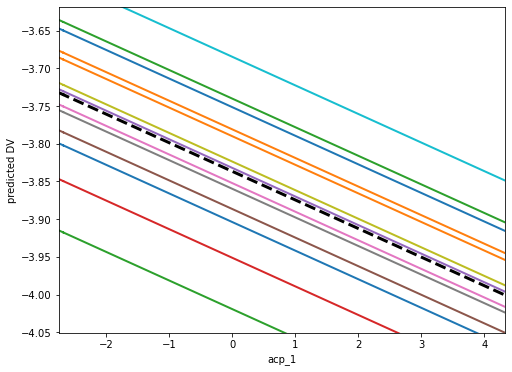

In [81]:
model.plot("acp_1", plot_ci=False, ylabel="predicted DV")

In [82]:
# Initialize model instance using 1 predictor with random intercepts 
model = Lmer("P50 ~  Groupclim + (1|site)", data=df_restricted)

# Fit it
print(model.fit())

Formula: P50~Groupclim+(1|site)

Family: gaussian	 Inference: parametric

Number of observations: 406	 Groups: {'site': 13.0}

Log-likelihood: -90.559 	 AIC: 181.118

Random effects:

                 Name    Var    Std
site      (Intercept)  0.015  0.121
Residual               0.085  0.291

No random effect correlations specified

Fixed effects:

                  Estimate  2.5_ci  97.5_ci     SE     DF  T-stat  P-val  Sig
(Intercept)         -3.969  -4.118   -3.821  0.076  9.516 -52.398  0.000  ***
Groupclimgroup_2     0.213   0.015    0.411  0.101  9.847   2.110  0.061    .
Groupclimgroup_3     0.208   0.026    0.391  0.093  9.709   2.235  0.050    .


In [83]:
print(model.anova())

SS Type III Analysis of Variance Table with Satterthwaite approximated degrees of freedom:
(NOTE: Using original model contrasts, orthogonality not guaranteed)
         SS        MS  NumDF   DenomDF    F-stat     P-val Sig
0  0.497722  0.248861      2  9.933321  2.941646  0.099229   .


## Test with R

In [84]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from rpy2.robjects.packages import importr
from rpy2.robjects import r, pandas2ri

base = importr('base') 
stats = importr('stats')
graphics = importr('graphics')
utils = importr('utils')
ade4 = importr('ade4')
nlme = importr('nlme')
lme4 = importr('lme4')
lmertest = importr('lmerTest')


from rpy2.robjects.conversion import localconverter

import rpy2.ipython.html
rpy2.ipython.html.init_printing()

In [85]:
with localconverter(ro.default_converter + pandas2ri.converter):
    df_restricted_r = ro.conversion.py2rpy(df_restricted)

base.dim(df_restricted_r)

<rpy2.robjects.vectors.IntVector object at 0x7f644452b900> [RTYPES.INTSXP]
R classes: ('integer',)
[406, 7]

In [86]:
from rpy2.robjects.packages import importr
utils = importr('utils')

In [87]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [88]:
%%R -i df_restricted_r

require(tidyverse)
require(dplyr)
require(lme4)
require(nlme)
require(lmerTest)
# glimpse(df_restricted_r)

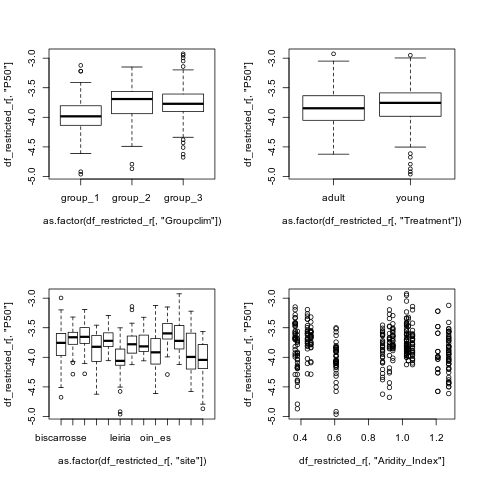

In [89]:
%%R
par(mfrow=c(2,2))
# df_restricted_r = df_restricted_r[(df_restricted_r[,'site']!='oin_es' & df_restricted_r[,'site']!='san vicente'),]
plot(df_restricted_r[,'P50']~as.factor(df_restricted_r[,'Groupclim']))
plot(df_restricted_r[,'P50']~as.factor(df_restricted_r[,'Treatment']))
plot(df_restricted_r[,'P50']~as.factor(df_restricted_r[,'site']))
plot(df_restricted_r[,'P50']~df_restricted_r[,'Aridity_Index'])

In [90]:
%%R
levels(as.factor(df_restricted_r[,'site']))

 [1] "biscarrosse" "cerbere"     "ceret"       "hourtin"     "la teste"   
 [6] "leiria"      "lit et mixe" "mimizan"     "oin_es"      "perpignan"  
[11] "ribeira"     "san vicente" "spain dune" 


In [91]:
%%R
df = df
df_restricted_r[,'Treatment'] = as.factor(df_restricted_r[,'Treatment'] )
df_restricted_r[,'site'] = as.factor(df_restricted_r[,'site'] )
df_restricted_r[,'Groupclim'] = as.factor(df_restricted_r[,'Groupclim'] )
mm1 = lmer(P50 ~ Treatment + acp_1 + (1|site), data = df_restricted_r)
summary(mm1)


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: P50 ~ Treatment + acp_1 + (1 | site)
   Data: df_restricted_r

REML criterion at convergence: 184.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2522 -0.4752 -0.0206  0.6228  2.8482 

Random effects:
 Groups   Name        Variance Std.Dev.
 site     (Intercept) 0.01136  0.1066  
 Residual             0.08451  0.2907  
Number of obs: 406, groups:  site, 13

Fixed effects:
                Estimate Std. Error        df  t value Pr(>|t|)    
(Intercept)     -3.83641    0.03609  14.89827 -106.291   <2e-16 ***
Treatmentyoung   0.03389    0.02908 393.27862    1.165   0.2446    
acp_1           -0.03797    0.01308  10.74928   -2.903   0.0147 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) Trtmnt
Treatmntyng -0.384       
acp_1        0.088  0.045


In [92]:
%%R
df_restricted_r[,'Treatment'] = as.factor(df_restricted_r[,'Treatment'] )
df_restricted_r[,'site'] = as.factor(df_restricted_r[,'site'] )
df_restricted_r[,'Groupclim'] = as.factor(df_restricted_r[,'Groupclim'] )
mm1 = lmer(P50 ~ Treatment + Groupclim + (1|site), data = df_restricted_r)
summary(mm1)


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: P50 ~ Treatment + Groupclim + (1 | site)
   Data: df_restricted_r

REML criterion at convergence: 184.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2550 -0.4761 -0.0115  0.6269  2.8545 

Random effects:
 Groups   Name        Variance Std.Dev.
 site     (Intercept) 0.01479  0.1216  
 Residual             0.08450  0.2907  
Number of obs: 406, groups:  site, 13

Fixed effects:
                  Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)       -3.98299    0.07678   9.97361 -51.875 1.82e-13 ***
Treatmentyoung     0.03467    0.02909 393.19745   1.192   0.2340    
Groupclimgroup_2   0.21001    0.10121   9.85837   2.075   0.0651 .  
Groupclimgroup_3   0.20390    0.09345   9.73682   2.182   0.0548 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) Trtmnt Grpc_2
Treatmntyng -0.151              

In [93]:
%%R
df_restricted_r[,'Treatment'] = as.factor(df_restricted_r[,'Treatment'] )
df_restricted_r[,'site'] = as.factor(df_restricted_r[,'site'] )
df_restricted_r[,'Groupclim'] = as.factor(df_restricted_r[,'Groupclim'] )
mm1 = lmer(P50 ~ Treatment + Aridity_Index + (1|site), data = df_restricted_r)
summary(mm1)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: P50 ~ Treatment + Aridity_Index + (1 | site)
   Data: df_restricted_r

REML criterion at convergence: 185.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2961 -0.4510 -0.0128  0.6250  2.8235 

Random effects:
 Groups   Name        Variance Std.Dev.
 site     (Intercept) 0.02207  0.1486  
 Residual             0.08448  0.2907  
Number of obs: 406, groups:  site, 13

Fixed effects:
                Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)     -3.78334    0.12401  11.60400 -30.507 1.92e-12 ***
Treatmentyoung   0.03649    0.02907 393.74218   1.255    0.210    
Aridity_Index   -0.05206    0.14086  11.21241  -0.370    0.719    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) Trtmnt
Treatmntyng -0.123       
Aridty_Indx -0.929  0.011


In [94]:
%%R
# intraclass correlation coefficient
0.02207/(0.02207+0.08448)
# Design effect
1 + (10-1)*0.2071328
# Neffective
(12*10) / 2.864195

[1] 41.89659


In [95]:
%%R
anova(mm1, type='II')

     Sum.Sq   Mean.Sq NumDF     DenDF  F.value    Pr..F.
1 0.1330809 0.1330809     1 393.74218 1.575277 0.2101868
2 0.0115390 0.0115390     1  11.21241 0.136587 0.7185831


In [96]:
%%R
AIC(mm1)

[1] 195.9497


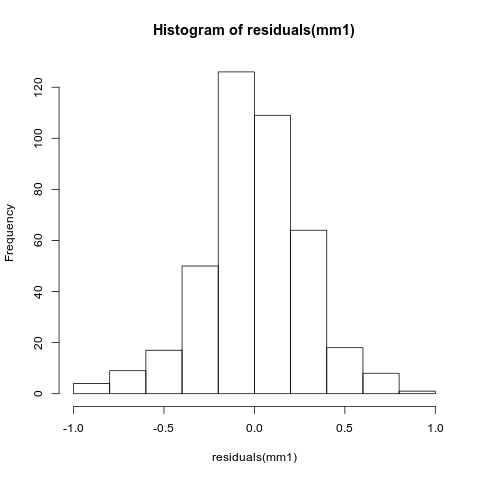

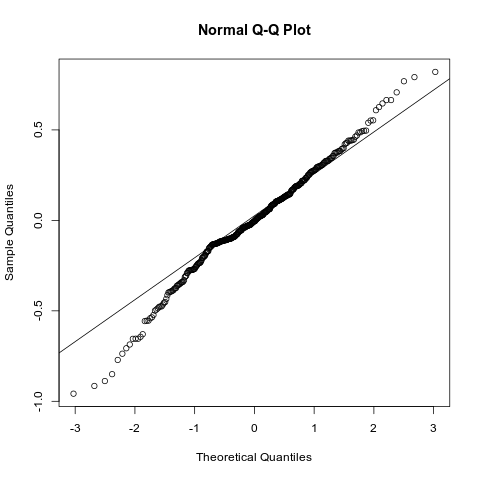

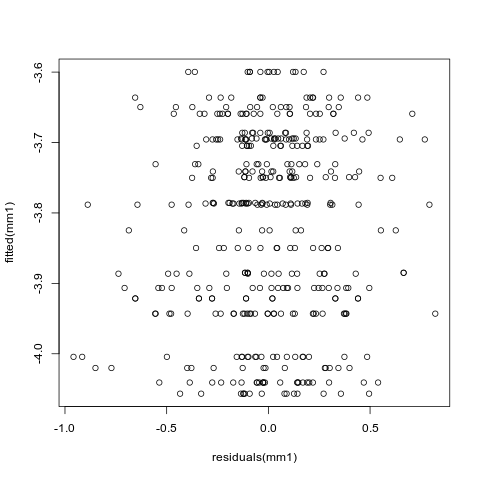

In [97]:
%%R
hist(residuals(mm1))
qqnorm(residuals(mm1))
qqline(residuals(mm1))

plot(fitted(mm1)~residuals(mm1))


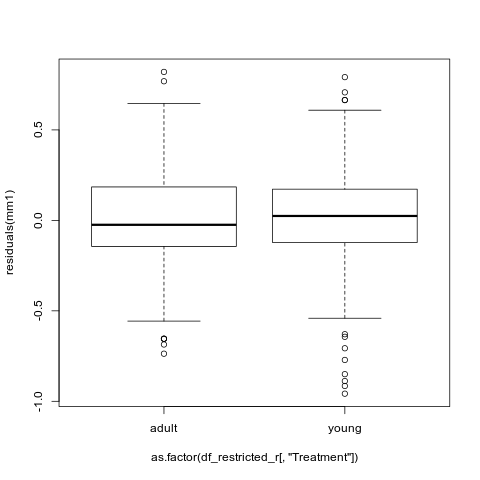

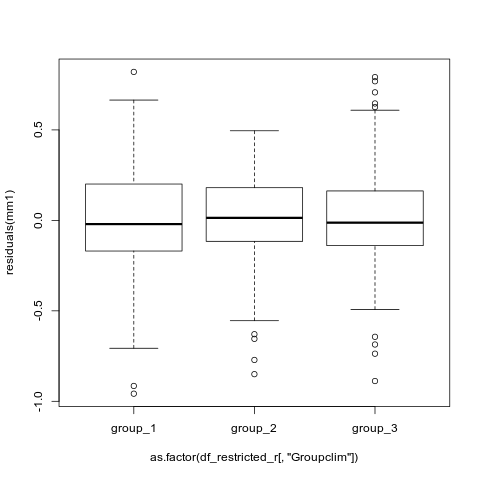

In [98]:
%%R
plot(residuals(mm1)~as.factor(df_restricted_r[,'Treatment']))
plot(residuals(mm1)~as.factor(df_restricted_r[,'Groupclim']))

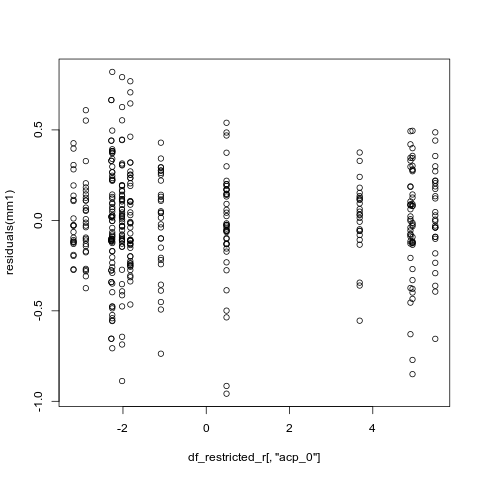

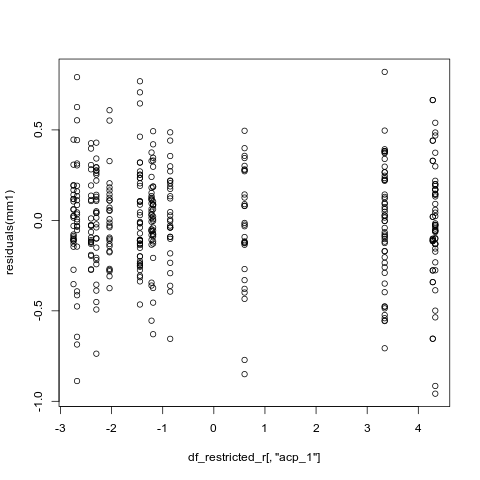

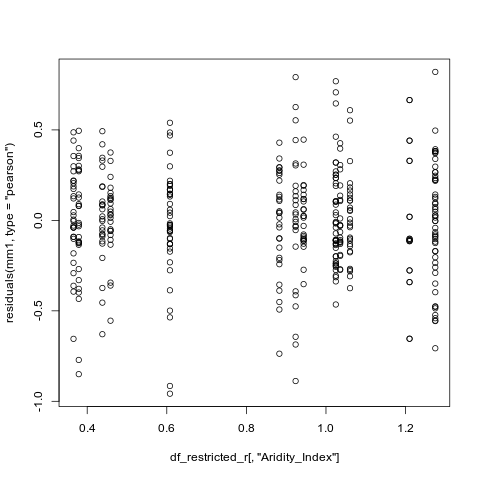

In [99]:
%%R
plot(residuals(mm1)~df_restricted_r[,'acp_0'])
plot(residuals(mm1)~df_restricted_r[,'acp_1'])
plot(residuals(mm1, type = 'pearson')~df_restricted_r[,'Aridity_Index'])

In [100]:
%%R

M0 =  gls(P50 ~ Treatment + Aridity_Index + acp_1, method = "REML", data = df_restricted_r)
M1 = lme(P50 ~ Treatment + acp_1, random = ~ 1|site, method = "REML", data = df_restricted_r)
M2 = lme(P50 ~ Treatment + Aridity_Index, random = ~ 1|site, method = "REML", data = df_restricted_r)

AIC(M0,M1, M2)

  df      AIC
1  5 222.2684
2  5 194.1070
3  5 195.9497


**There is a need for a random site effect**

# Conclusions

**The main results are :**

- **There is no Treatment effect**
- **There is no link between P50 & Aridity**
- **There is a site effect (i.e. variability among sites)**
- **Variability within site is higher than between sites**


___

## TEST FOR PLOTTING MAP

In [ ]:
# https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html
import os
os.environ['PROJ_LIB'] = r'/home/xavier/anaconda3/pkgs/proj4-5.2.0-he6710b0_1/share/proj'
from mpl_toolkits.basemap import Basemap

In [636]:
# cities = pd.read_csv('data/california_cities.csv')

# Extract the data we're interested in
lat = df_mean_pp.y_mean.values # cities['latd'].values
lon = df_mean_pp.x_mean.values
population = df_mean_pp.P50_mean.values*1
area = df_mean_pp.P50_mean.values*-1

In [635]:
population

array([3.80039957, 3.70158136, 3.65027189, 3.87533273, 3.70804224,
       4.04394229, 3.76219338, 3.75966157, 3.93413515, 3.59664881,
       3.6656569 , 3.92492006, 4.07258082])

<ipython-input-639-0f63c2e8b94d>:3: MatplotlibDeprecationWarning:


The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.

<ipython-input-639-0f63c2e8b94d>:9: MatplotlibDeprecationWarning:


The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.

<ipython-input-639-0f63c2e8b94d>:10: MatplotlibDeprecationWarning:


The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.



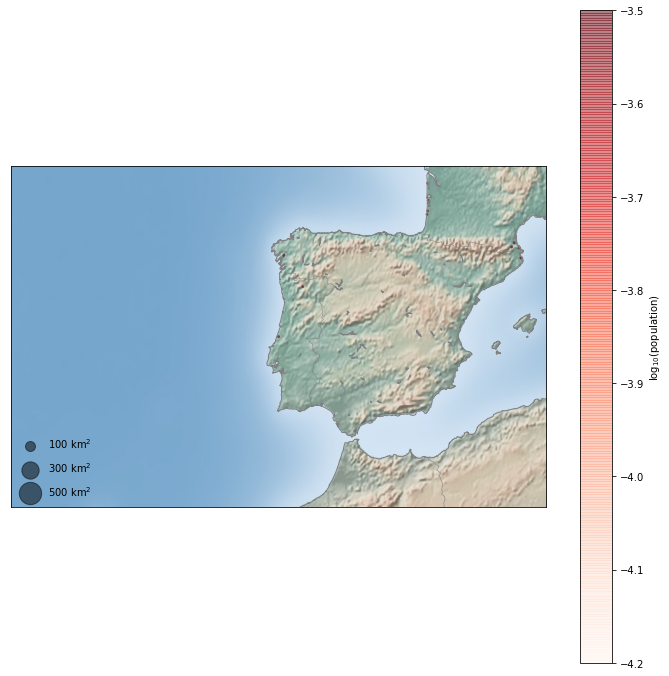

In [639]:
# 1. Draw the map background
fig = plt.figure(figsize=(12, 12))
m = Basemap(projection='lcc', resolution='h', 
            lat_0=df_mean_pp.y_mean.min(), lon_0=df_mean_pp.x_mean.min(),
            width=2.2E6, height=1.4E6)

m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True,
          c=population, 
          s=area,
          cmap='Reds',
          alpha=0.5)

# 3. create colorbar and legend
plt.colorbar(label=r'$\log_{10}({\rm population})$')
plt.clim(-4.2, -3.5)

# make legend with dummy points
for a in [100, 300, 500]:
    plt.scatter([], [], c='k', alpha=0.5, s=a,
                label=str(a) + ' km$^2$')
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left');

In [647]:
# https://towardsdatascience.com/reading-and-visualizing-geotiff-images-with-python-8dcca7a74510
import rasterio
from rasterio.plot import show

In [645]:
strmap = '/home/xavier/Downloads/7504448/global-ai_et0/ai_et0/ai_et0.tif'
dataset = rasterio.open(strmap)

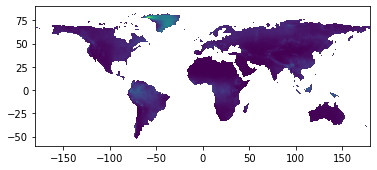

In [648]:
show(dataset)

In [651]:
df_mean_pp.y_mean.tolist()

[44.45235699999999,
 42.440112,
 42.502796,
 45.17666928999999,
 44.558046999999995,
 39.759839999999954,
 44.03869999999999,
 44.163000000000004,
 42.759458,
 42.65296800000001,
 41.59606000000003,
 42.45000000000001,
 42.05999999999997]

In [ ]:
lat = df_mean_pp_T.y_mean.values.min()# cities['latd'].values
lon = df_mean_pp.x_mean.values
population = df_mean_pp.P50_mean.values*1
area = df_mean_pp.P50_mean.values*-1

In [662]:
Basemap()

[[-3.802081874316891, -3.799453266958566],
 [-3.7594268145203995, -3.6389154467864646],
 [-3.596480166992467, -3.704063610084492],
 [-3.942611552547299, -3.808053907443479],
 [-3.7192735083530217, -3.698415440333292],
 [-4.016166503952736, -4.077273223347817],
 [-3.837545991756642, -3.681458436097889],
 [-3.867720921260384, -3.6417786492599604],
 [-3.9515063511327555, -3.910721784442335],
 [-3.5734148745098877, -3.621542316204947],
 [-3.649270300889763, -3.6820435031343837],
 [-4.006074536686552, -3.735559607875667],
 [-4.04494946918179, -4.102185840967392]]

<ipython-input-692-4d7fc204078c>:36: MatplotlibDeprecationWarning:


The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.

<ipython-input-692-4d7fc204078c>:51: MatplotlibDeprecationWarning:


The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.

<ipython-input-692-4d7fc204078c>:52: MatplotlibDeprecationWarning:


The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.



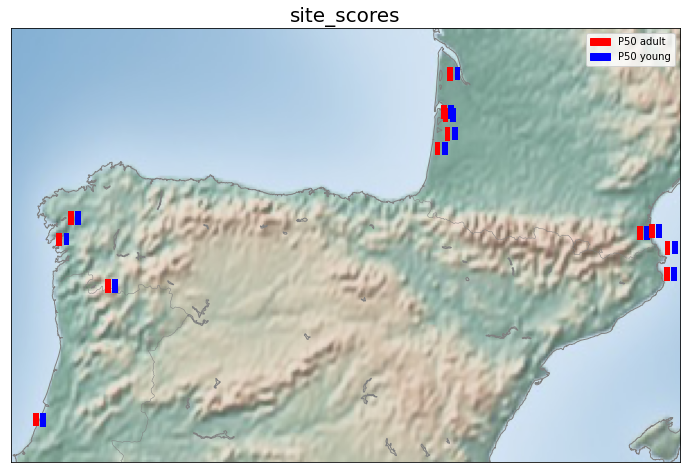

In [692]:
# https://stackoverflow.com/questions/55854988/subplots-onto-a-basemap
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# prep values for map extents and more
llcrnrlat = df_mean_pp.y_mean.values.min()-0.5
llcrnrlon = df_mean_pp.x_mean.values.min()-0.5
urcrnrlat = df_mean_pp.y_mean.values.max()+0.5
urcrnrlon = df_mean_pp.x_mean.values.max()+0.8
mid_lon = (urcrnrlon+llcrnrlon)/2.0
hr_lon = (urcrnrlon-llcrnrlon)/2.0
mid_lat = (urcrnrlat+llcrnrlat)/2.0
hr_lat = (urcrnrlat-llcrnrlat)/2.0

# function to create inset axes and plot bar chart on it
# this is good for 3 items bar chart
def build_bar(mapx, mapy, ax, width, xvals=['a','b'], yvals=[1,4], fcolors=['r','b']):
    ax_h = inset_axes(ax, width=width, \
                    height=width, \
                    loc=3, \
                    bbox_to_anchor=(mapx, mapy), \
                    bbox_transform=ax.transData, \
                    borderpad=0, \
                    axes_kwargs={'alpha': 0.35, 'visible': True})
    for x,y,c in zip(xvals, yvals, fcolors):
        ax_h.bar(x, y, label=str(x), fc=c)
    #ax.xticks(range(len(xvals)), xvals, fontsize=10, rotation=30)
    ax_h.axis('off')
    return ax_h

fig, ax = plt.subplots(figsize=(12, 12))  # bigger is better

bm = Basemap(llcrnrlat= llcrnrlat,
             llcrnrlon= llcrnrlon,
             urcrnrlat= urcrnrlat,
             urcrnrlon= urcrnrlon,
             ax = ax,
             resolution='h',
             projection='lcc',
             lon_0=mid_lon,
             lat_0=mid_lat)

# bm.fillcontinents(color='gray', zorder=0)
# bm.drawcoastlines(color='gray', linewidth=0.3, zorder=2)

bm.shadedrelief()
bm.drawcoastlines(color='gray')
bm.drawcountries(color='gray')
bm.drawstates(color='gray')

plt.title('site_scores', fontsize=20)

# ======================
# make-up some locations
# ----------------------
# you may use 121 here
lon1s = df_mean_pp.x_mean + np.random.normal(loc=0,scale=0.1, size = len(df_mean_pp.x_mean))
lat1s = df_mean_pp.y_mean + np.random.normal(loc=0,scale=0.1, size = len(df_mean_pp.x_mean))



# make-up list of 3-values data for the locations above
# -----------------------------------------------------
bar_data = np.array([[item] for i, item in enumerate(df_mean_pp_T.P50_mean)]).reshape(-1,2).tolist() # list of 3 items lists


# create a barchart at each location in (lon1s,lat1s)
# ---------------------------------------------------
bar_width = 0.1  # inch
colors = ['r','b']
for ix, lon1, lat1 in zip(list(range(len(lon1s))), lon1s, lat1s):
    x1, y1 = bm(lon1, lat1)   # get data coordinates for plotting
    bax = build_bar(x1, y1, ax, 0.2, xvals=['a','b'], \
              yvals=bar_data[ix], \
              fcolors=colors)

# create legend (of the 3 classes)
patch0 = mpatches.Patch(color=colors[0], label='P50 adult')
patch1 = mpatches.Patch(color=colors[1], label='P50 young')
ax.legend(handles=[patch0,patch1], loc=1)

plt.show()

In [693]:
# https://stackoverflow.com/questions/45677300/how-to-plot-geotiff-data-in-specific-area-lat-lon-with-python
import georaster


ModuleNotFoundError: No module named 'georaster'

In [695]:
import georaster

ImportError: cannot import name 'osr' from 'osgeo' (/home/xavier/anaconda3/lib/python3.8/site-packages/osgeo/__init__.py)

In [ ]:

fig = plt.figure(figsize=(8,8))

# full path to the geotiff file
fpath = r"C:\\path_to_your\geotiff_file\srtm_57_10.tif"  # Thailand east

# read extent of image without loading
# good for values in degrees lat/long
# geotiff may use other coordinates and projection
my_image = georaster.SingleBandRaster(strmap, load_data=False)

# grab limits of image's extent
minx, maxx, miny, maxy = my_image.extent

# set Basemap with slightly larger extents
# set resolution at intermediate level "i"
m = Basemap( projection='cyl', \
            llcrnrlon=minx-2, \
            llcrnrlat=miny-2, \
            urcrnrlon=maxx+2, \
            urcrnrlat=maxy+2, \
            resolution='i')

m.drawcoastlines(color="gray")
m.fillcontinents(color='beige')

# load the geotiff image, assign it a variable
image = georaster.SingleBandRaster( fpath, \
                        load_data=(minx, maxx, miny, maxy), \
                        latlon=True)

# plot the image on matplotlib active axes
# set zorder to put the image on top of coastlines and continent areas
# set alpha to let the hidden graphics show through
plt.imshow(image.r, extent=(minx, maxx, miny, maxy), zorder=10, alpha=0.6)

plt.show()

In [ ]:
lat = df_mean_pp_T.y_mean.values.min()# cities['latd'].values
lon = df_mean_pp.x_mean.values
population = df_mean_pp.P50_mean.values*1
area = df_mean_pp.P50_mean.values*-1

<ipython-input-682-d54f0b1ecb7a>:36: MatplotlibDeprecationWarning:


The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.

<ipython-input-682-d54f0b1ecb7a>:51: MatplotlibDeprecationWarning:


The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.

<ipython-input-682-d54f0b1ecb7a>:52: MatplotlibDeprecationWarning:


The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.



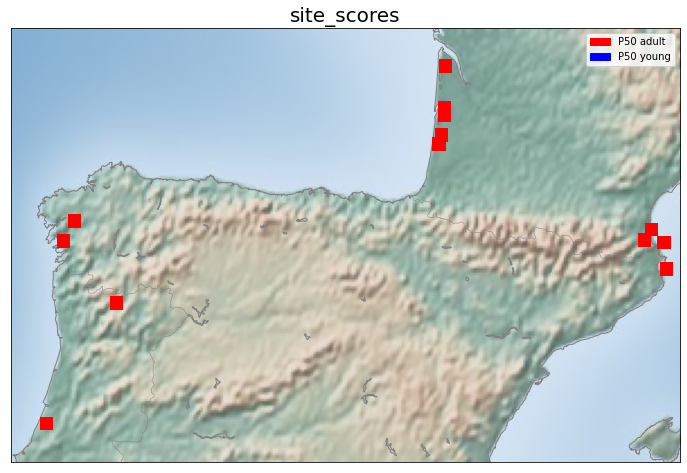

In [682]:
# https://stackoverflow.com/questions/55854988/subplots-onto-a-basemap
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# prep values for map extents and more
llcrnrlat = df_mean_pp.y_mean.values.min()-0.5
llcrnrlon = df_mean_pp.x_mean.values.min()-0.5
urcrnrlat = df_mean_pp.y_mean.values.max()+0.5
urcrnrlon = df_mean_pp.x_mean.values.max()+0.8
mid_lon = (urcrnrlon+llcrnrlon)/2.0
hr_lon = (urcrnrlon-llcrnrlon)/2.0
mid_lat = (urcrnrlat+llcrnrlat)/2.0
hr_lat = (urcrnrlat-llcrnrlat)/2.0

# function to create inset axes and plot bar chart on it
# this is good for 3 items bar chart
def build_bar(mapx, mapy, ax, width, xvals=['a','b'], yvals=[1,4], fcolors=['r','b']):
    ax_h = inset_axes(ax, width=width, \
                    height=width, \
                    loc=3, \
                    bbox_to_anchor=(mapx, mapy), \
                    bbox_transform=ax.transData, \
                    borderpad=0, \
                    axes_kwargs={'alpha': 0.35, 'visible': True})
    for x,y,c in zip(xvals, yvals, fcolors):
        ax_h.bar(x, y, label=str(x), fc=c)
    #ax.xticks(range(len(xvals)), xvals, fontsize=10, rotation=30)
    ax_h.axis('off')
    return ax_h

fig, ax = plt.subplots(figsize=(12, 12))  # bigger is better

bm = Basemap(llcrnrlat= llcrnrlat,
             llcrnrlon= llcrnrlon,
             urcrnrlat= urcrnrlat,
             urcrnrlon= urcrnrlon,
             ax = ax,
             resolution='h',
             projection='lcc',
             lon_0=mid_lon,
             lat_0=mid_lat)

# bm.fillcontinents(color='gray', zorder=0)
# bm.drawcoastlines(color='gray', linewidth=0.3, zorder=2)

bm.shadedrelief()
bm.drawcoastlines(color='gray')
bm.drawcountries(color='gray')
bm.drawstates(color='gray')

plt.title('site_scores', fontsize=20)

# ======================
# make-up some locations
# ----------------------
# you may use 121 here
lon1s = df_mean_pp.x_mean.tolist()
lat1s = df_mean_pp.y_mean.tolist()

# make-up list of 3-values data for the locations above
# -----------------------------------------------------
bd = [[bd[0]-bd[1]] for bd in bar_data] # list of 3 items lists


# create a barchart at each location in (lon1s,lat1s)
# ---------------------------------------------------
bar_width = 0.1  # inch
colors = ['r']
for ix, lon1, lat1 in zip(list(range(len(lon1s))), lon1s, lat1s):
    x1, y1 = bm(lon1, lat1)   # get data coordinates for plotting
    bax = build_bar(x1, y1, ax, 0.2, xvals=['a'], \
              yvals=bd[ix], \
              fcolors=colors)

# create legend (of the 3 classes)
patch0 = mpatches.Patch(color=colors[0], label='P50 adult')
ax.legend(handles=[patch0,patch1], loc=1)

plt.show()